## The genomic regions in question

In `03_compartments.ipynb` we extracted the genomic intervals of A compartments on all cell types in all combinations of the following parameters:

* Cell type: fibroblast, spermatocyte, pachytene spermatocyte, round spermatid, sperm
* Chromosome: X
* E1 restriction: full-chromosome, chromosome arms, 10Mb windows
* Resolution: 100 kb, 500 kb

The following parameter was only changed for 100kb resolution:

* Smoothing: No smoothing, 5 bins (500kb) 

Resulting in **45** .csv files. They are saved to `../results/compartments/`.


### Load the data

In [183]:
import pandas as pd
import os

# Directory containing your .csv files
csv_dir = '../results/compartments/'

# Create a dictionary to store the DataFrames
dataframes = {}

# Iterate over all .csv files in the directory
for filename in os.listdir(csv_dir):
    if filename.endswith('.csv'):  # Check for .csv files
        # Construct the full file path
        filepath = os.path.join(csv_dir, filename)
        
        # Load the CSV into a DataFrame
        # Use the filename (without extension) as the dictionary key
        key = filename.replace('_a_comp_coords_', '_')
        key = os.path.splitext(key)[0]
        dataframes[key] = pd.read_csv(filepath)

# The `dataframes` dictionary now contains the DataFrames
dataframes.keys()

ech90 = pd.read_csv('../data/ech90_human_Mmul_10.csv')


## Time to unleash `genominterv` on the .csv files


### Modules

In [152]:
import genominterv
import pandas as pd

### Define a plotting function

In [153]:
# Kaspers plotting function
 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%config InlineBackend.figure_format = 'svg'

def plot_intervals(query=None, annot=None, **kwargs):

    tups = []
    if query is not None:
        tups.append(('query', query))
    if annot is not None:
        tups.append(('annot', annot))
    tups.extend(kwargs.items())
    tups = reversed(tups)

    df_list = []
    labels = []
    for label, df in tups:
        labels.append(label)
        df['label'] = label
        df_list.append(df)
    bigdf = pd.concat(df_list)

    bigdf['chrom'] = pd.Categorical(bigdf['chrom'], bigdf['chrom'].unique())
    bigdf['label'] = pd.Categorical(bigdf['label'], bigdf['label'].unique())

    gr = bigdf.groupby('chrom', observed=False)
    fig, axes = plt.subplots(gr.ngroups, 1, figsize=(8, 1.5*gr.ngroups), 
                            sharey=True
                            #  sharex=True
                             )
    if type(axes) is not np.ndarray:
        # in case there is only one axis so it not returned as a list
        axes = np.array([axes])
    
    # with plt.style.context(('default')):

    for i, chrom in enumerate(gr.groups):
        _df = gr.get_group(chrom)
        _gr = _df.groupby('label', observed=False)
        for y, label in enumerate(_gr.groups):
            try:
                df = _gr.get_group(label)
            except KeyError:
                continue
            y = np.repeat(y, df.index.size)
            axes[i].hlines(y, df.start.tolist(), df.end.tolist(), alpha=0.5, lw=5, colors=f'C{y[0]}')
            delta = len(labels)/10
            axes[i].vlines(df.start.tolist(), y-delta, y+delta, alpha=0.5, lw=2, colors=f'C{y[0]}')
            axes[i].vlines(df.end.tolist(), y-delta, y+delta, alpha=0.5, lw=2, colors=f'C{y[0]}')

        axes[i].spines['top'].set_visible(False)
        axes[i].spines['left'].set_visible(False)
        axes[i].spines['right'].set_visible(False)

        axes[i].set_yticks(list(range(len(labels))), labels)
        axes[i].tick_params(axis='y', which='both', left=False)
        axes[i].set_ylim(-1, len(labels)-0.7)
        # axes[i].set_xlim(df.start.min()-delta, df.end.max()+delta)
        if i != gr.ngroups-1:
            axes[i].tick_params(axis='x', which='both', bottom=False)

        axes[i].set_title(chrom, loc='left', fontsize=10)
    plt.tight_layout()

In [154]:
# My plotting function

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1 import make_axes_locatable
from genominterv import interval_intersect

%config InlineBackend.figure_format = 'svg'



def plot_regions(annot, query=None, intersect=None):
    chrom = annot['chrom'].unique()[0]
    chromsize = pd.read_csv('../data/rheMac10.filtered.chrom.sizes', sep='\t', header=None, names=['chrom', 'size'])
    chromsize = chromsize[chromsize['chrom'] == chrom]['size'].values[0]
    print(chromsize)
    
    # Define the plot
    height = 1 + (1 if query is not None else 0) + (1 if intersect is not None else 0)*0.5

    f, ax = plt.subplots(figsize=(8, height), sharex=True)
    ax.spines[:].set_visible(False)

    # Plot the annot
    # Iterate over each interval in the DataFrame
    for start, end in zip(annot['start'], annot['end']):
        rect = Rectangle((start, 0.1), width=end-start, height=0.9, color='tab:red', linewidth=0, alpha=0.6)
        ax.add_patch(rect)
        ax.spines['bottom'].set_visible(True)
        ax.set_ylabel('A-Comp', rotation=0, fontsize=10, labelpad=20)

    
    divider = make_axes_locatable(ax)

    if query is not None:
        qax = divider.append_axes("top", size="100%", pad=0.2, sharex=ax)
        qax.xaxis.set_visible(False)
        # Plot the query
        for start, end in zip(query['start'], query['end']):
            rect = Rectangle((start, 0.1), width=end-start, height=0.9, color='tab:blue', linewidth=0, alpha=0.6)
            qax.add_patch(rect)
            qax.spines[:].set_visible(False)
            qax.set_yticks([]) 
            qax.set_title(chrom, loc='left', fontsize=10)
            qax.set_ylabel('ECH90', rotation=0, fontsize=10, labelpad=20)
    
    if intersect is not None:
        iax = divider.append_axes("bottom", size="100%", pad=0.2, sharex=ax)
        # Invisible x-axis for 'annot' (intersect ie below) 
        ax.xaxis.set_visible(False)
        # Plot the intersect
        for start, end in zip(intersect['start'], intersect['end']):
            rect = Rectangle((start, 0.1), width=end-start, height=0.9, color='tab:green', linewidth=0, alpha=0.6)
            iax.add_patch(rect)
            iax.spines[:].set_visible(False)
            iax.set_yticks([]) 
            ax.spines['bottom'].set_visible(False)
            iax.spines['bottom'].set_visible(True)
            iax.set_ylabel('Intersect', rotation=0, fontsize=10, labelpad=20)



    ax.set_yticks([])
    ax.set_xlim(0, chromsize)
    ticks = np.linspace(0, chromsize, num=5)
    ax.set_xticks(ticks) 
    ax.set_xticklabels([f'{int(t/1e6)} Mbp' for t in ticks])
    plt.tight_layout()



### Test with a subsample of the data

153388924


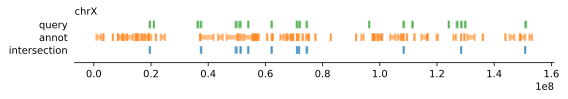

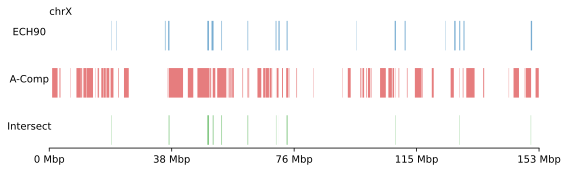

In [155]:

annot = dataframes['round_spermatid_100kb_arms']
query = ech90
intersect = interval_intersect(annot, query)

plot_intervals(query, annot, intersection=intersect)
plot_regions(annot, query, intersect)

Tests for round_spermatid_100kb_arms_smoothed


Proximity: TestResult(statistic=0.20566666666666641, pvalue=0.1078)
Jaccard: 0.03319511172796144

Tests for round_spermatid_100kb_arms
Proximity: TestResult(statistic=0.49242857142857144, pvalue=0.0005)
Jaccard: 0.03916232332293147

Tests for round_spermatid_100kb_10Mb
Proximity: TestResult(statistic=0.3223076923076922, pvalue=0.0231)
Jaccard: 0.04512778341139746

Tests for round_spermatid_100kb_10Mb_smoothed
Proximity: TestResult(statistic=0.4658333333333337, pvalue=0.002)
Jaccard: 0.04494391747197651



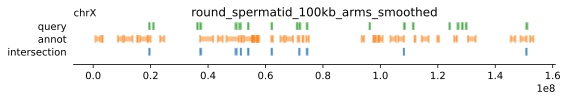

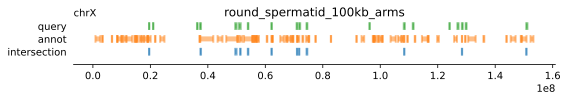

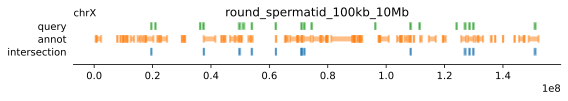

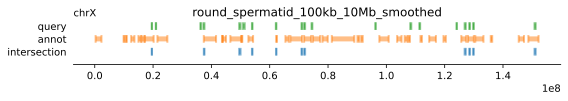

In [156]:
from genominterv import proximity_test, interval_collapse, interval_diff, interval_intersect, jaccard

annot = dataframes['fibroblast_500kb_arms']
query = ech90

#plot_intervals(query=query, annot=annot)

for key,annot in dataframes.items():
    # Filter out subset
    if ('round_spermatid_100') in key and not 'full' in key:
        # Plot the intervals
        intersection = interval_intersect(query, annot)
        plot_intervals(query=query, annot=annot, intersection=intersection)
        plt.title(key)

        # Do a proximity test
        print(f"Tests for {key}")
        annot_collapsed = interval_collapse(annot)
        non_ovl_query = interval_diff(query, annot_collapsed)
        print("Proximity:", proximity_test(non_ovl_query, annot_collapsed))
        print("Jaccard:", jaccard(query, annot))
        print()



### Bootstrap to get a p-value

In [157]:
from genominterv import bootstrap

annot = dataframes['round_spermatid_100kb_arms']
chromsizes = pd.read_csv('../data/rheMac10.filtered.chrom.sizes', sep='\t', index_col='chrom', header=None, names=['chrom','size']).to_dict()['size']
#display(chromsizes)

@bootstrap(chromsizes, samples=1000)
def jaccard_bootstrap(query, annot):
    return jaccard(query, annot)

jacccard_stat, p_value = jaccard_bootstrap(query, annot)

In [158]:
jacccard_stat, p_value

(0.03916232332293147, 0.283)

### Partition the A-compartments into regions *around* the edges 

In [171]:
df = dataframes['round_spermatid_100kb_arms']

start_edge = pd.DataFrame({
    'chrom': df['chrom'],
    'start': df['start']-1*df['resolution'],
    'end': df['start']+1*df['resolution'],
    'resolution': df['resolution'],
    'label': 'start_edge'
})
end_edge = pd.DataFrame({
    'chrom': df['chrom'],
    'start': df['end']-1*df['resolution'],
    'end': df['end']+1*df['resolution'],
    'resolution': df['resolution'],
    'label': 'end_edge'
})

#df
pd.concat([start_edge, end_edge]).sort_values(['chrom', 'start', 'end'])

,chrom,start,end,resolution,label
0,chrX,800000,1000000,100000,start_edge
0,chrX,2500000,2700000,100000,end_edge
1,chrX,3100000,3300000,100000,start_edge
1,chrX,3400000,3600000,100000,end_edge
2,chrX,6500000,6700000,100000,start_edge
...,...,...,...,...,...
69,chrX,149000000,149200000,100000,end_edge
70,chrX,149200000,149400000,100000,start_edge
70,chrX,150800000,151000000,100000,end_edge
71,chrX,152200000,152400000,100000,start_edge


In [178]:
import os

for key, df in dataframes.items():
    outdir = '../results/edges'
    edge_csv_name = os.path.join(outdir,f'{key+'_edges.csv'}')
    start_edge = pd.DataFrame({
        'chrom': df['chrom'],
        'start': df['start']-1*df['resolution'],
        'end': df['start']+1*df['resolution'],
        'resolution': df['resolution'],
        'label': 'start_edge'
    })
    end_edge = pd.DataFrame({
        'chrom': df['chrom'],
        'start': df['end']-1*df['resolution'],
        'end': df['end']+1*df['resolution'],
        'resolution': df['resolution'],
        'label': 'end_edge'
    })

    if not os.path.exists(outdir):
        os.makedirs(outdir)

    pd.concat([start_edge, end_edge]).sort_values(['chrom', 'start', 'end']).to_csv(edge_csv_name, index=False)


### Import edges

In [181]:
import pandas as pd
import os

# Directory containing your .csv files
csv_dir = '../results/edges/'

# Create a dictionary to store the DataFrames
edges = {}

# Iterate over all .csv files in the directory
for filename in os.listdir(csv_dir):
    if filename.endswith('.csv'):  # Check for .csv files
        # Construct the full file path
        filepath = os.path.join(csv_dir, filename)
        
        # Load the CSV into a DataFrame
        # Use the filename (without extension) as the dictionary key
        key = filename.replace('_edges_', '')
        key = os.path.splitext(key)[0]
        edges[key] = pd.read_csv(filepath)

# The `edges` dictionary now contains the DataFrames
edges.keys()

#ech90 = pd.read_csv('../data/ech90_human_Mmul_10.csv')


dict_keys(['sperm_100kb_arms_smoothed_edges', 'spermatogonia_500kb_full_edges', 'pachytene_spermatocyte_100kb_10Mb_smoothed_edges', 'spermatogonia_100kb_arms_edges', 'fibroblast_500kb_full_edges', 'round_spermatid_500kb_10Mb_edges', 'fibroblast_100kb_arms_edges', 'spermatogonia_100kb_full_smoothed_edges', 'round_spermatid_100kb_full_smoothed_edges', 'round_spermatid_100kb_full_edges', 'fibroblast_100kb_10Mb_edges', 'round_spermatid_500kb_arms_edges', 'fibroblast_100kb_full_smoothed_edges', 'spermatogonia_100kb_10Mb_edges', 'sperm_500kb_arms_edges', 'spermatogonia_100kb_10Mb_smoothed_edges', 'sperm_100kb_full_edges', 'pachytene_spermatocyte_500kb_10Mb_edges', 'pachytene_spermatocyte_100kb_full_smoothed_edges', 'pachytene_spermatocyte_100kb_full_edges', 'pachytene_spermatocyte_500kb_arms_edges', 'fibroblast_100kb_10Mb_smoothed_edges', 'sperm_500kb_10Mb_edges', 'round_spermatid_100kb_10Mb_smoothed_edges', 'spermatogonia_500kb_arms_edges', 'spermatogonia_100kb_full_edges', 'spermatogonia_1

153388924
153388924
153388924


Text(0.5, 0.98, 'End edge')

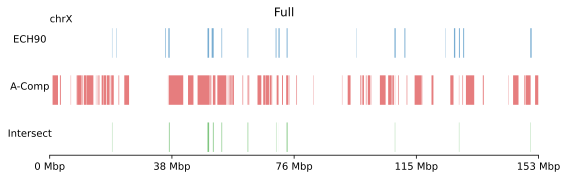

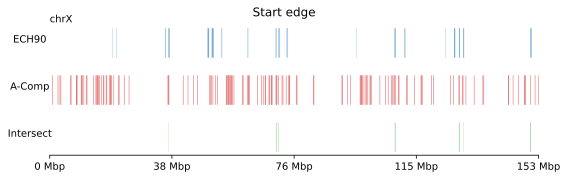

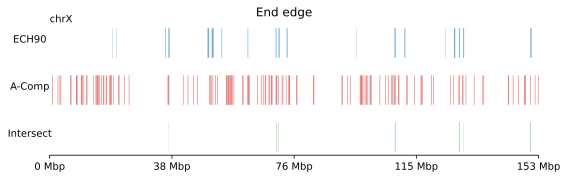

In [213]:
from genominterv import interval_intersect

full_df = dataframes['round_spermatid_100kb_arms']
full_intersect = interval_intersect(full_df, ech90)

edge_df = edges['round_spermatid_100kb_arms_edges']
start_edge_df = edge_df[edge_df['label']== 'start_edge']
end_edge_df = edge_df[edge_df['label']== 'end_edge']

start_edge_intersect = interval_intersect(start_edge_df, ech90)
end_edge_intersect = interval_intersect(end_edge_df, ech90)



# Plot full
plot_regions(full_df, ech90, full_intersect)
plt.suptitle('Full')

# Plot start edge
plot_regions(edge_df, ech90, edge_intersect)
plt.suptitle('Start edge')

# Plot end edge
plot_regions(edge_df, ech90, edge_intersect)
plt.suptitle('End edge')

In [228]:
# Determine the proportion of total regions in ECH90 that lies on compartment edges
display(full_intersect)
# Proportion of ECH90 on full regions
print('Full:', full_intersect.size / ech90.size)

# # Proportion of ECH90 on start edges
print('Start:', start_edge_intersect.size / ech90.size)

# # Proportion of ECH90 on end edges
print('End', end_edge_intersect.size / ech90.size)

,index,start,end,chrom
0,0,19536773,19636984,chrX
1,1,37400000,37632028,chrX
2,2,49516522,50014126,chrX
3,3,51200000,51444493,chrX
4,4,53902995,54106817,chrX
5,5,62100000,62293349,chrX
6,6,71000000,71100000,chrX
7,7,71788766,71800000,chrX
8,8,74341598,74635686,chrX
9,9,108300000,108400000,chrX


Full: 0.8421052631578947
Start: 0.42105263157894735
End 0.49122807017543857


<Axes: >

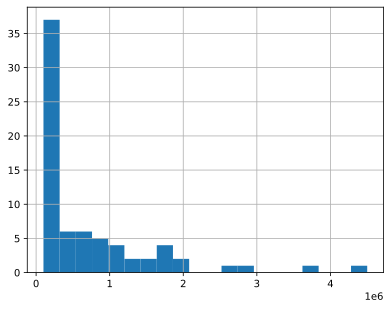

In [222]:
# Plot histogram of the lengths of the A compartments from the full regions

full_df['length'] = full_df['end'] - full_df['start']
full_df['length'].hist(bins=20)